In [94]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import keras
import tensorflow as tf

from wordcloud import WordCloud
from tensorflow.keras import layers, models, losses, optimizers, Sequential, metrics

In [95]:
# pip install seaborn -U

In [96]:
tweets_data = pd.read_csv('https://raw.githubusercontent.com/pantShubham95/NLP_NeuralNetwork/refs/heads/main/Dataset/Tweets.csv')
tweets_data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [97]:
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [98]:
tweets_data.isnull().sum()

,0
textID,0
text,1
selected_text,1
sentiment,0


In [99]:
 tweets_data = tweets_data.dropna()

In [100]:
tweets_data.duplicated().sum()

0

In [101]:
tweets_data = tweets_data.drop(columns=["selected_text","textID"])
tweets_data.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [102]:
tweets_data.sentiment.value_counts()

,count
sentiment,
neutral,11117
positive,8582
negative,7781


<Axes: xlabel='sentiment'>

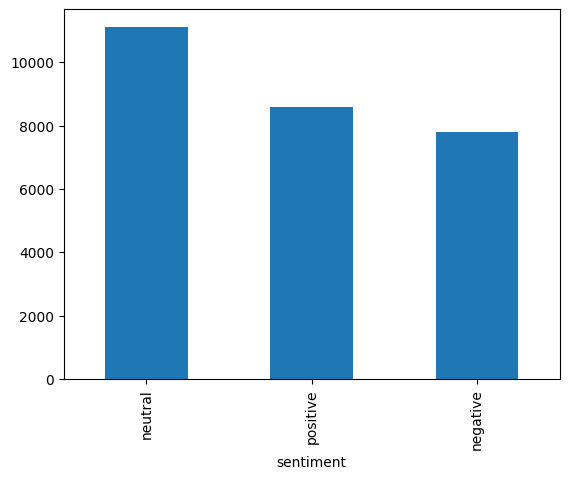

In [103]:
tweets_data.sentiment.value_counts().plot(kind='bar')

In [104]:
tweets_data["word_count"] = tweets_data["text"].apply(lambda x: len(str(x).split(" ")))
tweets_data[["text","word_count"]].head()

,text,word_count
0,"I`d have responded, if I were going",8
1,Sooo SAD I will miss you here in San Diego!!!,11
2,my boss is bullying me...,5
3,what interview! leave me alone,6
4,"Sons of ****, why couldn`t they put them on t...",15


In [105]:
tweets_data.groupby("sentiment")["word_count"].mean()

,word_count
sentiment,
negative,14.244313
neutral,13.207610
positive,14.100210


In [106]:
tweets_data.groupby("sentiment")["word_count"].median()

,word_count
sentiment,
negative,13.0
neutral,12.0
positive,13.0


<Axes: xlabel='word_count', ylabel='Count'>

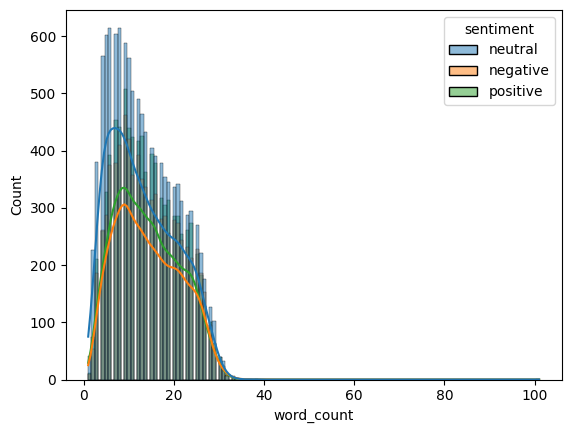

In [107]:
import seaborn as sns
sns.histplot(data= tweets_data, x = "word_count", hue = "sentiment", kde = True)

<Axes: ylabel='word_count'>

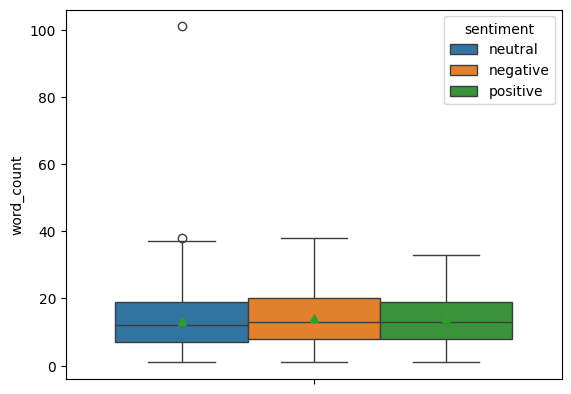

In [108]:
sns.boxplot(data= tweets_data, y = "word_count", hue = "sentiment", showmeans=True)

In [109]:
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = stopwords.words('english')

print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [110]:
import string

def custom_standardization(input_data):

    # Convert to lowercase
    lowercase = tf.strings.lower(input_data)

    # Remove URLs
    stripped_urls = tf.strings.regex_replace(lowercase, r"https?://\S+|www\.\S+", "")

    # Remove email addresses
    stripped_symbol = tf.strings.regex_replace(stripped_urls, "\S*@\S*\s?", "")

    # Remove text in angular brackets (usually HTML tags)
    stripped_brackets = tf.strings.regex_replace(stripped_symbol, "<.*?>+", "")

    # Remove any square brackets and leave the text within square brackets
    stripped_brackets = tf.strings.regex_replace(stripped_brackets, "\[|\]", "")

    # Matches alphanumeric characters with digits and remove those
    stripped_digits = tf.strings.regex_replace(stripped_brackets, "\w*\d\w*", "")

    # Remove stopwords
    stripped_stopwords = tf.strings.regex_replace(stripped_digits, r"\b(?:{})\b".format("|".join(stop_words)), "")

    # Replace multiple whitespaces with a single whitespace
    stripped_whitespace_chars = tf.strings.regex_replace(stripped_stopwords, "\s+", " ")

    # Remove non-alphabet characters
    return tf.strings.regex_replace(stripped_whitespace_chars ,r"[^a-zA-Z\s]+" ,"")

In [111]:
tweets_data['cleaned_text'] = tweets_data['text'].apply(lambda x: custom_standardization(x))

In [112]:
tweets_data

,text,sentiment,word_count,cleaned_text
0,"I`d have responded, if I were going",neutral,8,"tf.Tensor(b' responded going', shape=(), dtyp..."
1,Sooo SAD I will miss you here in San Diego!!!,negative,11,"tf.Tensor(b' sooo sad miss san diego', shape=(..."
2,my boss is bullying me...,negative,5,"tf.Tensor(b' boss bullying ', shape=(), dtype=..."
3,what interview! leave me alone,negative,6,"tf.Tensor(b' interview leave alone', shape=(),..."
4,"Sons of ****, why couldn`t they put them on t...",negative,15,tf.Tensor(b' sons put releases already bough...
...,...,...,...,...
27476,wish we could come see u on Denver husband l...,negative,18,tf.Tensor(b' wish could come see u denver husb...
27477,I`ve wondered about rake to. The client has ...,negative,26,tf.Tensor(b' wondered rake client made clear...
27478,Yay good for both of you. Enjoy the break - y...,positive,24,tf.Tensor(b' yay good enjoy break probably n...
27479,But it was worth it ****.,positive,8,"tf.Tensor(b' worth ', shape=(), dtype=string)"


In [113]:
# Define a function to convert tensor to string
def tensor_to_string(tensor):
    return tensor.numpy().decode("utf-8")  # Assuming utf-8 encoding

# Apply the function to the DataFrame column
tweets_data["cleaned_text"] = tweets_data["cleaned_text"].apply(tensor_to_string)

tweets_data

,text,sentiment,word_count,cleaned_text
0,"I`d have responded, if I were going",neutral,8,responded going
1,Sooo SAD I will miss you here in San Diego!!!,negative,11,sooo sad miss san diego
2,my boss is bullying me...,negative,5,boss bullying
3,what interview! leave me alone,negative,6,interview leave alone
4,"Sons of ****, why couldn`t they put them on t...",negative,15,sons put releases already bought
...,...,...,...,...
27476,wish we could come see u on Denver husband l...,negative,18,wish could come see u denver husband lost job...
27477,I`ve wondered about rake to. The client has ...,negative,26,wondered rake client made clear net force...
27478,Yay good for both of you. Enjoy the break - y...,positive,24,yay good enjoy break probably need hectic w...
27479,But it was worth it ****.,positive,8,worth


In [ ]:
# Extract the text from positive sentiment tweets
positive_tweets = tweets_data[tweets_data["sentiment"] == "positive"]["cleaned_text"]

# Concatenate all the positive sentiment tweets into a single string
positive_text = " ".join(positive_tweets)

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 400, background_color = "white").generate(positive_text)

# Plot the WordCloud
plt.figure(figsize = (10, 6))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.title("Word Cloud - Positive Sentiment")
plt.show()

In [ ]:
# Extract the text from negative sentiment tweets
negative_tweets = tweets_data[tweets_data["sentiment"] == "negative"]["cleaned_text"]

# Concatenate all the negative sentiment tweets into a single string
negative_text = " ".join(negative_tweets)

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 400, background_color = "white").generate(negative_text)

# Plot the WordCloud
plt.figure(figsize = (10, 6))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.title("Word Cloud - Negative Sentiment")
plt.show()

In [ ]:
# Extract the text from neutral sentiment tweets
neutral_tweets = tweets_data[tweets_data["sentiment"] == "neutral"]["cleaned_text"]

# Concatenate all the neutral sentiment tweets into a single string
neutral_tweets = " ".join(neutral_tweets)

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 400, background_color = "white").generate(neutral_tweets)

# Plot the WordCloud
plt.figure(figsize = (10, 6))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.title("Word Cloud - Neutral Sentiment")
plt.show()

In [ ]:
tweets_data["sentiment"] = tweets_data["sentiment"].replace({"negative": 0, "neutral": 1, "positive": 2})

tweets_data.head(10)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(tweets_data, test_size = 0.2, stratify = tweets_data["sentiment"], random_state = 123)
X_train, X_val = train_test_split(X_train, test_size = 0.1, stratify = X_train["sentiment"], random_state = 123)

X_train.shape, X_val.shape, X_test.shape

In [ ]:
X_train["sentiment"].value_counts(normalize=True)

In [ ]:
X_val["sentiment"].value_counts(normalize=True)

In [ ]:
X_test["sentiment"].value_counts(normalize=True)

In [ ]:
raw_train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train["text"].values, X_train["sentiment"].values)).shuffle(1024).batch(batch_size = 128)

raw_val_ds = tf.data.Dataset.from_tensor_slices(
    (X_val["text"].values, X_val["sentiment"].values)).batch(batch_size = 128)

raw_test_ds = tf.data.Dataset.from_tensor_slices(
    (X_test["text"].values, X_test["sentiment"].values)).batch(batch_size = 128)

len(raw_train_ds), len(raw_val_ds), len(raw_test_ds)

In [ ]:
vocab_size = 30

count_vectorizer = layers.TextVectorization(
    standardize = "lower_and_strip_punctuation",
    max_tokens = vocab_size,
    output_mode = "count",
)

In [ ]:
# list of text documents
text = ["Malcolm is an amazing painter. Malcolm also loves watching cricket",
        "Dean cooks well",
        "Malcolm is a decent footballer too",
        "Chris is a teacher, he is quite experienced in teaching"]

In [ ]:
count_vectorizer.adapt(text)

In [ ]:
count_vectorizer.get_vocabulary()

In [ ]:
count_vectorizer(text)

In [ ]:
vocab_size = 10000

count_vectorizer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size,
    output_mode = "count",
    ngrams = (1, 2)
)

In [ ]:
# Make a text-only dataset (without labels), then call adapt

train_text = raw_train_ds.map(lambda x, y: x)

count_vectorizer.adapt(train_text)

In [ ]:
def vectorize_text(text, label):
    # Shape () => (1, )
    text = tf.expand_dims(text, -1)

    return count_vectorizer(text), label

In [ ]:
import sys
np.set_printoptions(threshold = sys.maxsize)

class_names = ["negative", "neutral", "positive"]
text_batch, label_batch = next(iter(raw_train_ds))
first_tweet, first_label = text_batch[0], label_batch[0]

print("Tweet: ", first_tweet)
print("Sentiment: ", class_names[first_label])
print("Vectorized review: ", vectorize_text(first_tweet, first_label))

In [ ]:
count_vectorizer.get_vocabulary()

In [ ]:
vocab_size =  len(count_vectorizer.get_vocabulary())

vocab_size

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
dnn_model = Sequential([
    layers.Dense(64, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(32, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(3)
])

In [ ]:
dnn_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.0001),
    metrics = ["accuracy"]
)

input_shape = (None, 10000)

dnn_model.build(input_shape)

dnn_model.summary()

In [ ]:
history = dnn_model.fit(
    train_ds,
    epochs = 10,
    validation_data = val_ds)

In [ ]:
loss, accuracy = dnn_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

In [ ]:
history_dict = history.history

history_dict.keys()

In [ ]:
history_dict

In [ ]:
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color = "green", label = "Training loss")

plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")

plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

In [ ]:
export_model = Sequential([
  count_vectorizer,
  dnn_model
])

export_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.0001),
    metrics = ["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,\
                            classification_report

predictions = export_model.predict(X_test["text"].values)

y_pred = np.argmax(predictions , axis = 1)
y_test = X_test["sentiment"]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average = None)
precision = precision_score(y_test, y_pred, average = None)
recall = recall_score(y_test, y_pred, average = None)

# Get the classification report
report = classification_report(y_test,y_pred)

# Print the classification report
print(report)

In [ ]:
vocab_size = 30

tfidf_vectorizer = layers.TextVectorization(
    standardize = "lower_and_strip_punctuation",
    max_tokens = vocab_size,
    output_mode = "tf-idf",
)

In [ ]:
text = ["Malcolm is an amazing painter. Malcolm also loves watching cricket",
        "Dean cooks well",
        "Malcolm is a decent footballer too",
        "Chris is a teacher, he is quite experienced in teaching"]

In [ ]:
tfidf_vectorizer.adapt(text)

In [ ]:
tfidf_vectorizer.get_vocabulary()

In [ ]:
tfidf_vectorizer(text)

In [ ]:
vocab_size = 10000

tfidf_vectorizer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size,
    output_mode = "tf-idf",
    ngrams = (1, 2)
)

tfidf_vectorizer.adapt(train_text)

In [ ]:
tfidf_vectorizer.get_vocabulary()

In [ ]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return tfidf_vectorizer(text), label

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
dnn_model = Sequential([
    layers.Dense(64, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(32, activation = "tanh"),
    layers.Dropout(0.1),
    layers.Dense(3)
])

dnn_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.00001),
    metrics = ["accuracy"]
)

history = dnn_model.fit(
    train_ds,
    epochs = 40,
    validation_data = val_ds
)

In [ ]:
loss, accuracy = dnn_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

In [ ]:
history_dict = history.history
history_dict.keys()

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, color = "green", label = "Training loss")

plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")

plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

In [ ]:
export_model = Sequential([
  tfidf_vectorizer,
  dnn_model
])

export_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = optimizers.Adam(learning_rate = 0.00001),
    metrics = ["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
a, b, loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

In [ ]:
vocab_size = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = vocab_size,
    output_mode = "int",
    output_sequence_length = sequence_length
)

In [ ]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [ ]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
callback_list = [
    keras.callbacks.EarlyStopping(
        patience = 3,
        monitor = "val_accuracy"
    ),

    keras.callbacks.ReduceLROnPlateau(
        patience = 1,
        factor = 0.1,
    )
]

In [ ]:
embedding_dim = 64

model = Sequential([
  layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dense(64, activation = "tanh"),
  layers.Dropout(0.1),
  layers.Dense(32, activation = "tanh"),
  layers.Dropout(0.1),
  layers.Dense(3)]
)

model.summary()

In [ ]:
model.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
               loss = losses.SparseCategoricalCrossentropy(from_logits = True),
               metrics = ["accuracy"])

history = model.fit(
    train_ds,
    epochs = 50,
    validation_data = val_ds,
    callbacks = callback_list
)

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

In [ ]:
history_dict = history.history
history_dict.keys()

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, color = "green", label = "Training loss")

plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

In [ ]:
embedding_dim = 128

rnn_model = Sequential()

rnn_model.add(layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim))

rnn_model.add(layers.SimpleRNN(128, return_sequences = True))

rnn_model.add(layers.GlobalMaxPool1D())

rnn_model.add(layers.Dense(3, activation = "softmax"))

rnn_model.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
               loss = losses.SparseCategoricalCrossentropy(from_logits = False),
               metrics = ["accuracy"])

history = rnn_model.fit(
    train_ds,
    epochs = 20,
    validation_data = val_ds, callbacks = callback_list)

In [ ]:
loss, accuracy = rnn_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

In [ ]:
embedding_dim = 128

lstm_model = Sequential()

lstm_model.add(layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim))

lstm_model.add(layers.SpatialDropout1D(0.25))

lstm_model.add(layers.LSTM(128, dropout = 0.6, return_sequences = True))

lstm_model.add(layers.GlobalMaxPooling1D())

lstm_model.add(layers.Dense(32, activation = "tanh"))
lstm_model.add(layers.Dense(3, activation = "softmax"))

lstm_model.compile(optimizer = optimizers.Adam(learning_rate = 0.001),
               loss = losses.SparseCategoricalCrossentropy(from_logits = False),
               metrics = ["accuracy"])

history = lstm_model.fit(
    train_ds,
    epochs = 20,
    validation_data = val_ds, callbacks = callback_list)

In [ ]:
loss, accuracy = lstm_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

In [ ]:
history_dict = history.history
history_dict.keys()

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, color = "green", label = "Training loss")

plt.plot(epochs, val_loss, color = "orange", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
plt.plot(epochs, acc, color = "green", label = "Training acc")
plt.plot(epochs, val_acc, color = "orange", label = "Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")

plt.show()

In [ ]:
export_model = Sequential([
  vectorize_layer,
  lstm_model
])

export_model.compile(
    loss = losses.SparseCategoricalCrossentropy(from_logits = False),
    optimizer = optimizers.Adam(learning_rate = 0.001),
    metrics = ["accuracy"]
)

# Test it with `raw_test_ds`, which yields raw strings
a,b,loss,accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

In [ ]:
examples = [
  "this experience has been the worst, want my money back",
  "this AI related article is very good",
  "The movie was average" ]
examples = tf.expand_dims(examples, -1)
export_model.predict(examples)

In [ ]:
np.argmax(export_model.predict(examples), axis=1)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,\
                            classification_report

predictions = export_model.predict(raw_test_ds)
y_pred = np.argmax(predictions , axis = 1)

y_test = X_test["sentiment"]
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average = None)
precision = precision_score(y_test,y_pred, average = None)
recall = recall_score(y_test,y_pred, average = None)

# Get the classification report
report = classification_report(y_test,y_pred)

# Print the classification report
print(report)

In [ ]:
lstm_model.save("sentiment_predictor.keras")

In [ ]:
# Loading the saved model
loaded_model = models.load_model("sentiment_predictor.keras")
loss, accuracy = loaded_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)